# General data reader for AQUA 
## Example of datasets on Lumi

We added a few new data sources to the intake catalogue, pointing to resources already available on LUMI.

### Inspecting available datasets

Multiple datasets area available also for observations, so that we can also inspect the catalogue by checking what is inside. This can be done with the `inspect_catalogue` function

In [1]:
from aqua import catalogue, inspect_catalogue
cat = catalogue()

FESOM	test-pi	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- original_2d	original 2d output
	- original_3d	original 3d output

IFS	test-tco79	5km experiment, coupuled with IFS
	- original_2d	original 2d output
IFS	tco79-eORCA1	tco79-eORCA1 data
	- ICMGG_atm2d	



Here below a short exploration at cataogue, model and experiment level

In [2]:
inspect_catalogue(cat)

Models available in catalogue:


['FESOM', 'IFS']

In [3]:
inspect_catalogue(cat, model = 'IFS')

Experiments available in catalogue for model IFS:


['test-tco79', 'tco79-eORCA1']

In [4]:
inspect_catalogue(cat, model = 'IFS', exp = 'tco79-eORCA1')

Sources available in catalogue for model IFS and exp tco79-eORCA1:


['ICMGG_atm2d']

### IFS data

In [3]:
from aqua import Reader
reader = Reader(model="IFS", exp="tco79-eORCA1", source="ICMGG_atm2d",regrid='r100')

2023-05-11 13:41:57 :: Reader :: WARNING  -> Weights file not found: /pfs/lustrep3/projappl/project_465000454/padavini/aqua/weights/weights_IFS_tco79-eORCA1_ICMGG_atm2d_ycon_r100_l2d.nc
2023-05-11 13:41:57 :: Reader :: WARNING  -> Attempting to generate it ...
2023-05-11 13:41:57 :: Reader :: WARNING  -> Source grid: /pfs/lustrep3/scratch/project_465000454/AQUA-workflow/tco_grids/tco79_grid.nc
2023-05-11 13:41:59 :: Reader :: WARNING  -> Success!


In [4]:
data = reader.retrieve()

In [5]:
data

<xarray.Dataset>
Dimensions:    (time: 8305, value: 28480, level: 5)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * level      (level) int64 1 2 3 4 5
    lon        (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2020-01-20 ... 2020-12-31
Dimensions without coordinates: value
Data variables: (12/87)
    100si      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    100u       (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    100v       (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    10u        (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    10v        (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    2d         (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    ...         ...
    vike       (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vipie      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vipile     (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vithe      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    z          (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    zos        (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [9]:
dataplot = data.tprate.isel(time=[0,1,2,3,4])
dataplot = reader.regrid(dataplot)

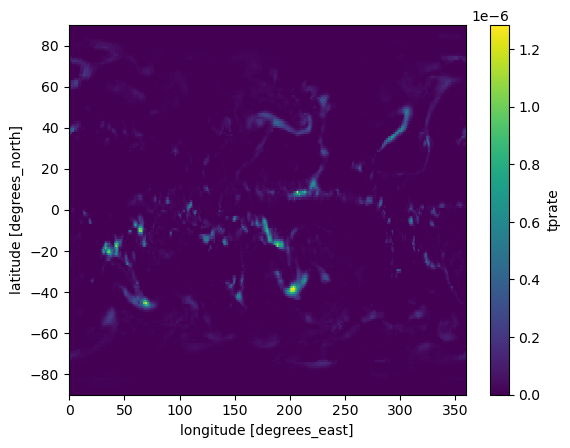

In [10]:
dataplot.mean("time").plot()

## FDB/GSV access

We implemented FDB access in the reader using the GSV reader interface and a new intake driver which we developed. Also in this case the idea is to 'shield' the users from complex mars-style requests, allowing them to focus on the desired variables and experiments.

For now only a "fdb-test" dataset is available, including some common climate variables, for a few days. as described in the [GSV Reader documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specification-of-fdb-test).

An important difference compared to other data sources is that in this case the reader always returns a generator object (a python iterator). This allows to take into consideration the fact that reading from FDB is not lazy and recreates some form of lazyness when working with the data. 

In [1]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test", regrid="r200")

In [2]:
data = reader.retrieve(startdate="20050401", enddate="20050404", var="tp")

The result is now an 'iterator'

In [3]:
data

<generator object FixerMixin._fixergen at 0x7f55e053edc0>

We can either loop over the iterator or just get the next value. It is only now that the reader will actually retrieve the field(s) from FDB:

In [3]:
data0 = next(data)

Correctly decoded tp     on level sfc    at 2005-04-01T00:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T01:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T02:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T03:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T04:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T05:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T06:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T07:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T08:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T09:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T10:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T11:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T12:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T13:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T14:00:00
Correctly decoded tp     on level sfc   

This is the first day. Let's instead loop over the next ones:

In [5]:
for d in data:
    dm = reader.fldmean(d).mean(dim="time").tp
    print(dm.values)

Correctly decoded tp     on level sfc    at 2005-04-02T00:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T01:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T02:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T03:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T04:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T05:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T06:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T07:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T08:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T09:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T10:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T11:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T12:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T13:00:00
Correctly decoded tp     on level sfc    at 2005-04-02T14:00:00
Correctly decoded tp     on level sfc   

The generator is now exhausted, let's get a fresh one

In [6]:
data = reader.retrieve(startdate="20050401", enddate="20050404", var="tp")

The regridder can also operate on iterators:

In [7]:
datar = reader.regrid(data)
datar

<generator object Reader._regridgen at 0x7f6db135ad50>

In [8]:
next(datar)

Correctly decoded tp     on level sfc    at 2005-04-01T00:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T01:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T02:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T03:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T04:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T05:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T06:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T07:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T08:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T09:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T10:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T11:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T12:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T13:00:00
Correctly decoded tp     on level sfc    at 2005-04-01T14:00:00
Correctly decoded tp     on level sfc   

<xarray.Dataset>
Dimensions:  (time: 24, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-04-01 ... 2005-04-01T23:00:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tp       (time, lat, lon) float64 dask.array<chunksize=(24, 90, 180), meta=np.ndarray>
Attributes:
    history:    2023-05-19 00:58:09 coordinates adjusted by AQUA fixer;\n2023...
    regridded:  1